In [4]:
import sys
import os

# Add the parent directory to the sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata, interp2d


from nv_files.Field_Generator import omega0_samples,omega0_samples_torch
from nv_files.FEM_Solver import VorticitySolver
from nv_files.Pseudo_Spectral_Solver import VorticitySolver2D

# Random Field Generator

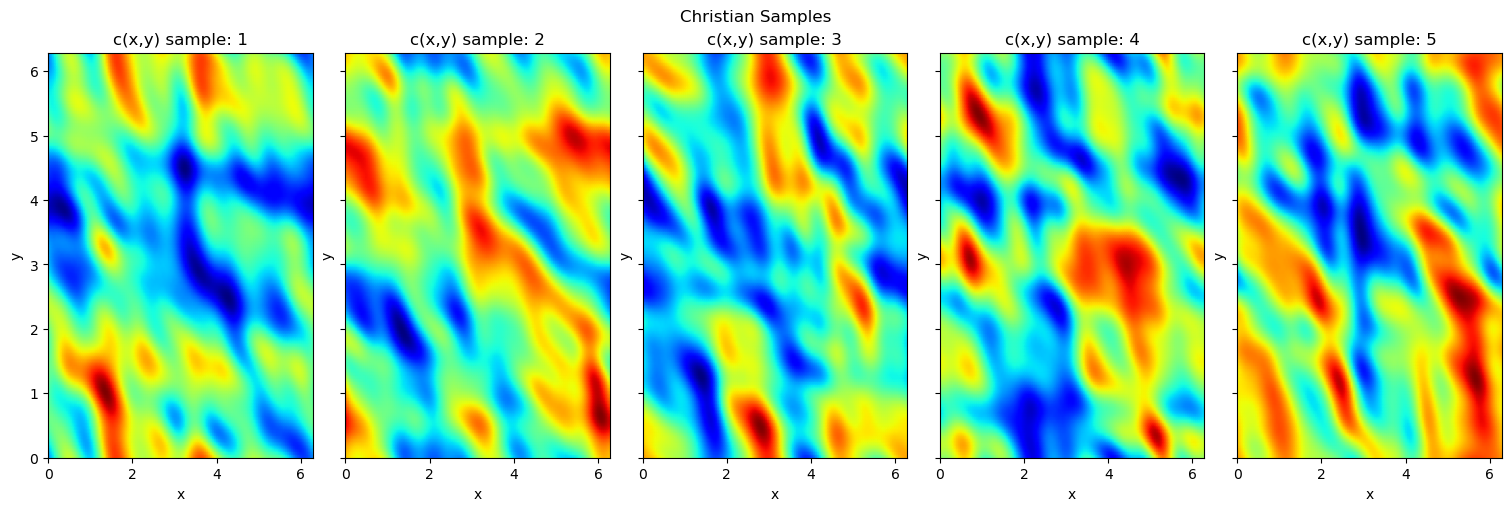

In [35]:
X = np.linspace(0, 1, 128)*2*np.pi  # Spatial grid in X direction
Y = np.linspace(0, 1, 128)*2*np.pi  # Spatial grid in Y direction
X, Y = np.meshgrid(X, Y)  # Create meshgrid for X, Y
n_samples = 5  # Number of samples you want to generate
seed = 108  # Base seed for reproducibility
N_KL = 100

rng = np.random.default_rng(seed)
theta = rng.normal(0, 1, (N_KL, 2,n_samples))

# Generate n samples of omega0
omega0_ = omega0_samples(X, Y, theta, d = 5,tau=7)

_, axs = plt.subplots(1,n_samples,figsize = (15,5), layout='constrained', sharey=True)
plt.suptitle("Christian Samples")
for i in range(n_samples):
    c = omega0_[:,:,i]

    axs[i].pcolormesh(X, Y, c, shading="gouraud", cmap = "jet")
    axs[i].set_xlabel("x"), axs[i].set_ylabel("y"), axs[i].set_title(f"c(x,y) sample: {i+1}")


In [34]:

def check_incompressibility_fourier(w_hat, solver):
    """
    Check incompressibility condition using Fourier space divergence calculation.

    Parameters:
        w_hat (ndarray): Vorticity in Fourier space.
        solver (VorticitySolver2D): Instance of the solver with grid and parameters.
    """
    # Solve for the stream function in Fourier space
    psi_hat = solver.solve_poisson(w_hat)

    # Compute velocity components in Fourier space
    u_hat = 1j * solver.ky * psi_hat
    v_hat = -1j * solver.kx * psi_hat

    # Compute divergence in Fourier space
    divergence_hat = 1j * (solver.kx * u_hat + solver.ky * v_hat)

    # Transform divergence back to real space
    divergence = np.fft.irfft2(divergence_hat, s=(solver.N, solver.N))

    # Check if the divergence is close to zero
    max_divergence = np.max(np.abs(divergence))
    print(f"Maximum divergence: {max_divergence:.2e}")
    
    assert max_divergence < 1e-10, "Incompressibility condition violated"
    print("Incompressibility condition satisfied (Fourier-based check).")

solver = VorticitySolver2D(N=128, L=1, T=10.0, nu=1e-2, dt=5e-4,num_sol=200, method='CN')

omega0_hat = np.fft.rfft2(omega0_[:,:,0])

# Check incompressibility
check_incompressibility_fourier(omega0_hat, solver)

Maximum divergence: 1.88e-20
Incompressibility condition satisfied (Fourier-based check).


# FEM Approach

In [ ]:

def forcing_function(x):
    return 0.1 * (np.sin(2 * np.pi * (x[0] + x[1])) + np.cos(2 * np.pi * (x[0] + x[1])))

fem_solver = VorticitySolver(nx=32, ny=32, N_KL=100, dt=0.01, T=10.0, nu=1e-4, force_func=None, d= 5, tau =10,seed = 108)

fem_solver.run()

Text(0, 0.5, 'y')

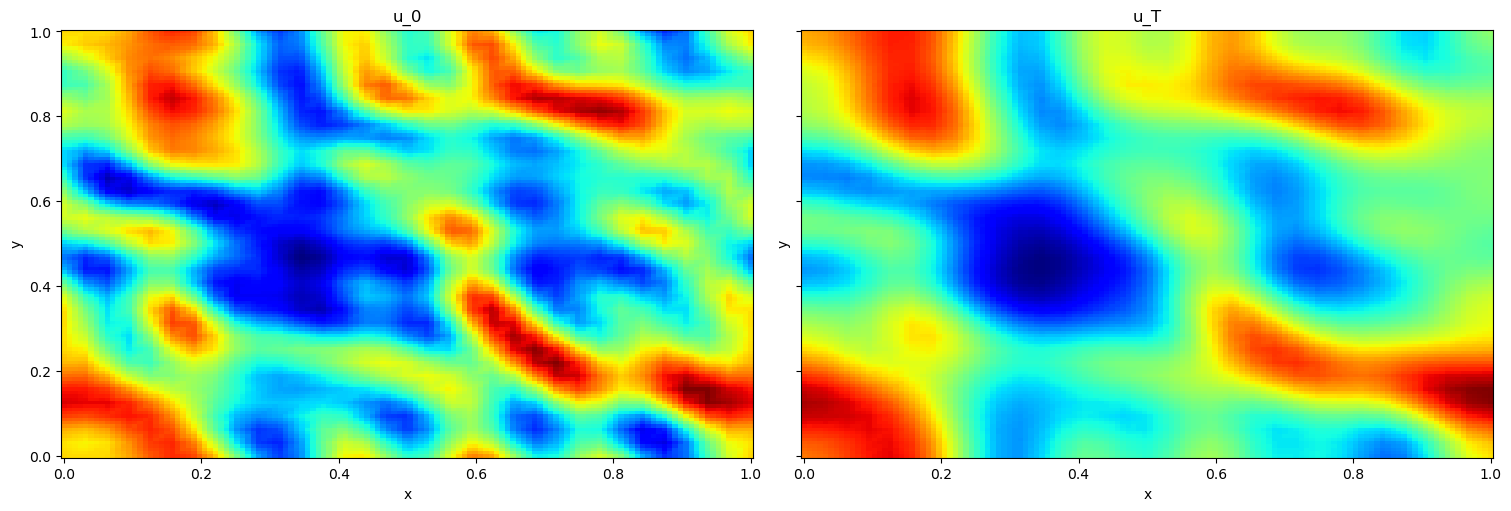

In [22]:
N = 128
xgrid = np.linspace(0,1,N)
X, Y = np.meshgrid(xgrid, xgrid)

points = np.column_stack((X.ravel(), Y.ravel(), np.zeros_like(X.ravel())))  # shape (N, 3)

u_0,u_values =  fem_solver.evaluate_at_points(points)

fig, axs = plt.subplots(1,2,figsize = (15,5), layout='constrained', sharey=True)

z_0 = griddata((X.reshape(-1), Y.reshape(-1)), u_0.flatten(),
                   (X, Y), method='cubic')


z_pred = griddata((X.reshape(-1), Y.reshape(-1)), u_values.flatten(),
                   (X, Y), method='cubic')

# Plot the first subplot (Solution Visualization for u_0)
cp0 = axs[0].pcolormesh(X, Y, z_0, cmap='jet')
axs[0].set_title("u_0")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")

# Plot the second subplot (Solution Visualization for u_values)
cp1 = axs[1].pcolormesh(X, Y, z_pred, cmap='jet')
axs[1].set_title("u_T")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")

# Pseudo Spectral Method

In [36]:
solver = VorticitySolver2D(N=128, L=1, T=2.0, nu=1e-2, dt=5e-4,num_sol=200, method='CN')

results = solver.run_simulation( np.array(omega0_[:,:,0]))

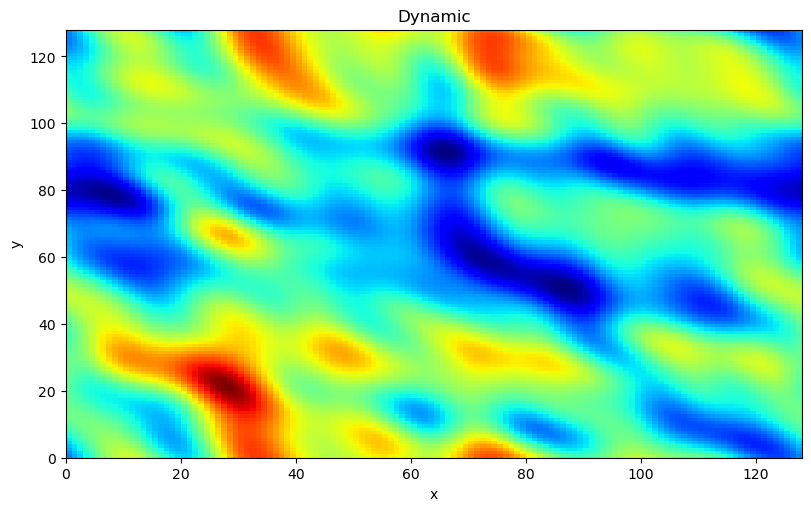

In [37]:
from matplotlib.animation import FuncAnimation, PillowWriter

fig, axs = plt.subplots(1,1,figsize = (8,5), layout='constrained', sharey=True)

def animate(i):
    w0 = results[i]

    # Plot the first subplot (Solution Visualization for u_0)
    im1 = axs.pcolormesh(w0, cmap='jet')
    #fig.colorbar(im1)
    axs.set_title(r"Dynamic")
    axs.set_xlabel("x")
    axs.set_ylabel("y")

    return im1

ani = FuncAnimation(fig, animate, interval=1, blit=False, repeat=True, frames=200)    
ani.save("NVs_psm.gif", dpi=200, writer=PillowWriter(fps=50))

In [28]:
import jax.numpy as jnp

data = jnp.load("./ns_tori.npy", allow_pickle=True).item()
w_ref = data["w"]

In [29]:
solver = VorticitySolver2D(N=128, L=1, T=10.0, nu=1e-2, dt=5e-4,num_sol=200, method='CN')

results = solver.run_simulation( np.array(w_ref[0,:,:]))

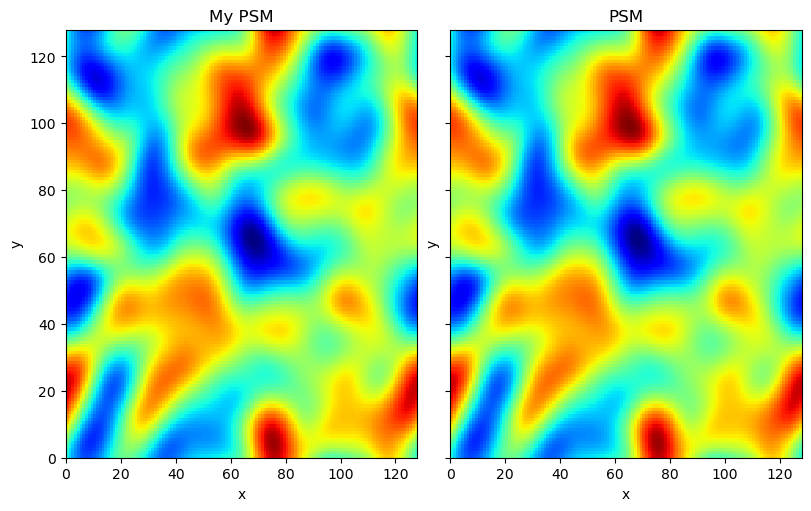

In [7]:
from matplotlib.animation import FuncAnimation, PillowWriter

fig, axs = plt.subplots(1,2,figsize = (8,5), layout='constrained', sharey=True)

def animate(i):
    w0 = results[i]

    # Plot the first subplot (Solution Visualization for u_0)
    im1 = axs[0].pcolormesh(w0, cmap='jet')
    #fig.colorbar(im1)
    axs[0].set_title(r"My PSM")
    axs[0].set_xlabel("x")
    axs[0].set_ylabel("y")

    im2 = axs[1].pcolormesh(w_ref[i,:,:], cmap='jet')
    #fig.colorbar(im1)
    axs[1].set_title(r"PSM")
    axs[1].set_xlabel("x")
    axs[1].set_ylabel("y")

    return im1,im2

ani = FuncAnimation(fig, animate, interval=1, blit=False, repeat=True, frames=200)    
ani.save("NVs_comparison.gif", dpi=200, writer=PillowWriter(fps=50))

## PSM with Force

In [8]:
def force_function(X, Y):
    return 0.1 * (np.sin(X + Y) + np.cos(X + Y))

solver = VorticitySolver2D(N=128, L=1, T=10.0, nu=1e-2, dt=5e-4,num_sol=50, method='CN', force=force_function)

results = solver.run_simulation( np.array(w_ref[0,:,:]))

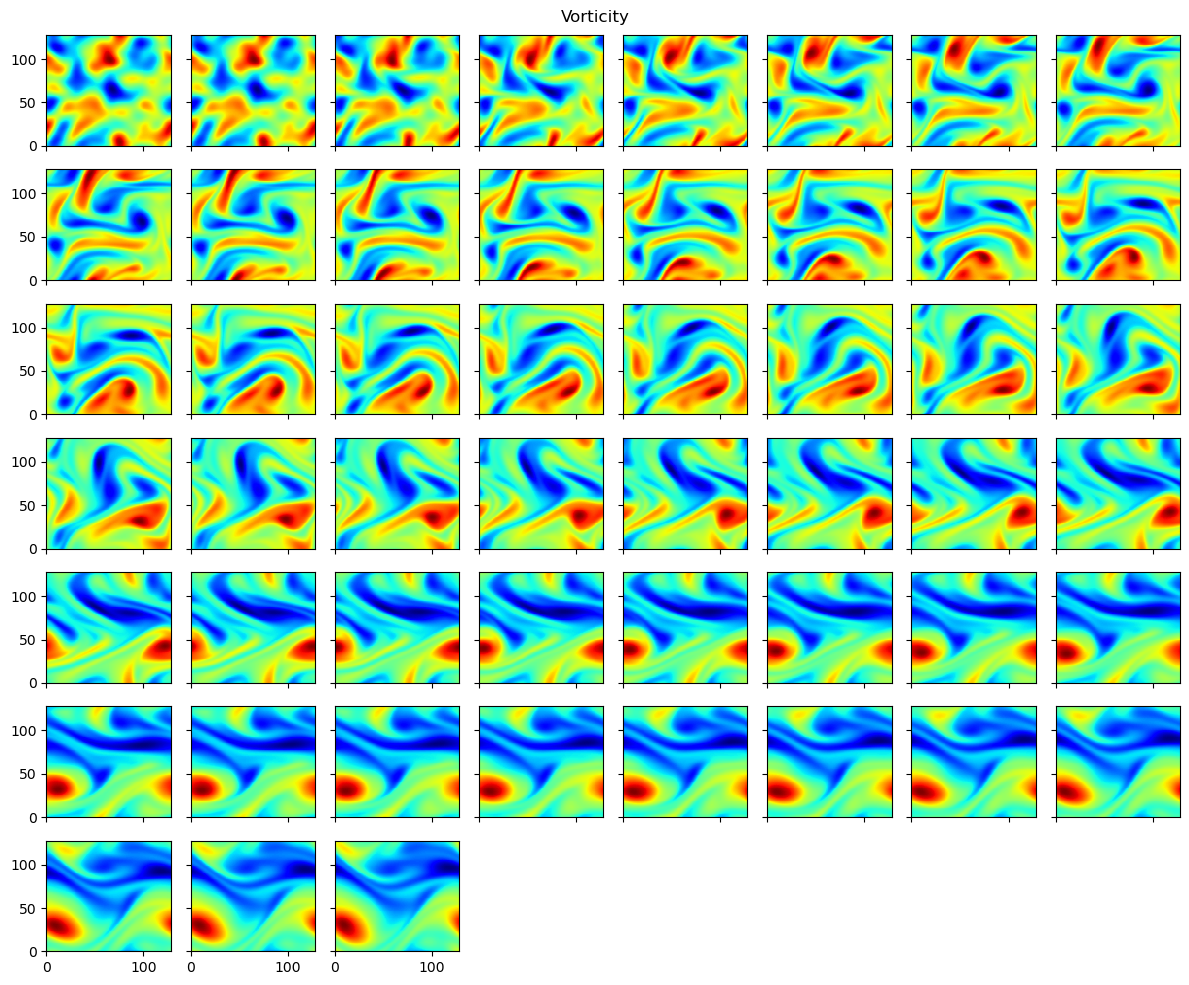

In [9]:
num_plots = len(results)
cols = int(np.ceil(np.sqrt(num_plots)))
rows = int(np.ceil(num_plots / cols))

# Create a figure and subplots
fig, axs = plt.subplots(rows, cols, figsize=(12, 10),sharex = True, sharey = True)
fig.suptitle("Vorticity")

# Flatten axes array for easy iteration if there's more than 1 row
axs = axs.flatten() if num_plots > 1 else [axs]

# Loop through each vorticity field in w_list and plot it
for i,j in enumerate(range(0,num_plots)):
    im = axs[i].pcolormesh(results[j], cmap="jet")
    #axs[i].set_title(f"Step {i*100}")
    #fig.colorbar(im, ax=axs[i])

# Hide any unused subplots
for j in range(i + 1, len(axs)):
    axs[j].axis("off")

plt.tight_layout()
plt.show()

# Convergence

In [29]:
seed = 108
N = 128
N_KL = 50
T = 1
dt = 5e-4
nu = 1e-2

xgrid = np.linspace(0,1,N)
X, Y = np.meshgrid(xgrid, xgrid)

#FEM
def force_function_FEM(x):
    return 0.1 * (np.sin(2 * np.pi * (x[0] + x[1])) + np.cos(2 * np.pi * (x[0] + x[1])))

fem_solver = VorticitySolver(nx=32, ny=32, N_KL=N_KL, dt=dt,T=T,nu=nu,force_func=force_function_FEM, d= 5, tau =10,seed = 108)

fem_solver.run()

points = np.column_stack((X.ravel(), Y.ravel(), np.zeros_like(X.ravel())))  # shape (N, 3)

u_0,u_final = fem_solver.evaluate_at_points(points)

z_0 = griddata((X.reshape(-1), Y.reshape(-1)), u_0.flatten(),(X, Y), method='cubic')

z_final = griddata((X.reshape(-1), Y.reshape(-1)), u_final.flatten(),(X, Y), method='cubic')


In [32]:
# PSM
xgrid = np.linspace(0,2*np.pi,N)
X, Y = np.meshgrid(xgrid, xgrid)
rng = np.random.default_rng(seed)
theta = rng.normal(0, 1, (N_KL, 2,1))

def force_function(X, Y):
    return 0.1 * (np.sin(X + Y) + np.cos(X + Y))

w0 = omega0_samples(X, Y, theta, d = 5,tau=10)

solver = VorticitySolver2D(N=128, L=1, T=T, nu=nu, dt=dt,num_sol=50, method='CN', force=force_function)

results = solver.run_simulation( np.array(w0[:,:,0]))

Text(0.5, 0, 'x')

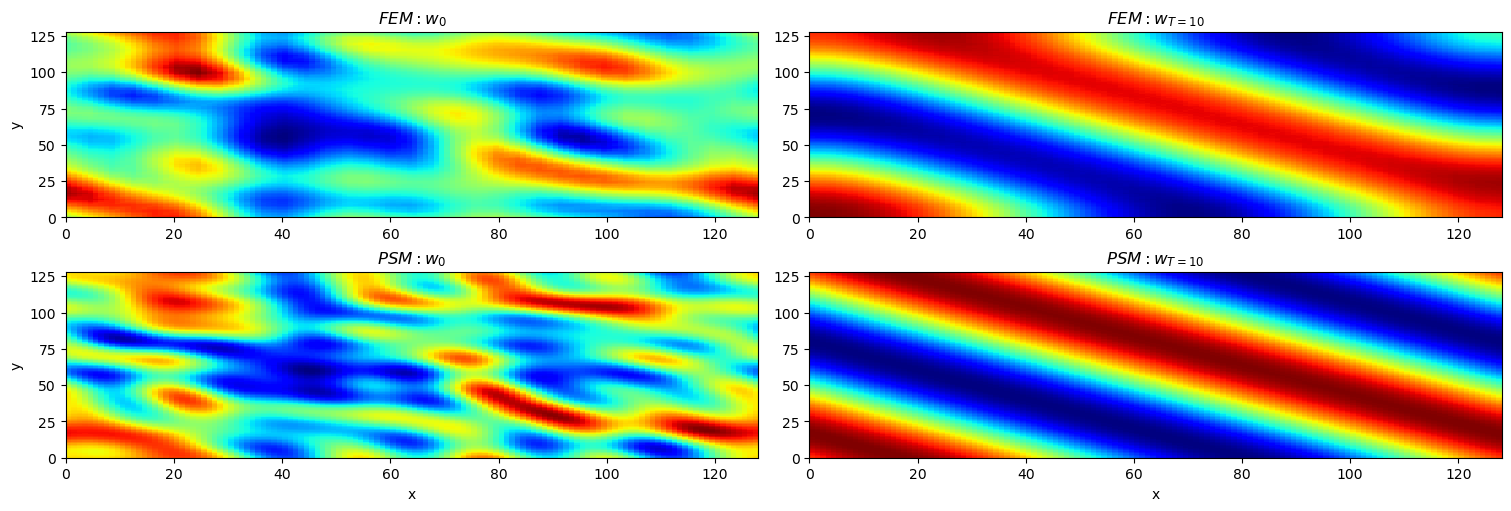

In [33]:
fig, axs = plt.subplots(2,2,figsize = (15,5), layout='constrained')

# Plot the first subplot (Solution Visualization for u_0)
cp0 = axs[0,0].pcolormesh(z_0, cmap='jet')
axs[0,0].set_title(r"$FEM: w_{0}$")
axs[0,0].set_ylabel("y")

# Plot the second subplot (Solution Visualization for u_values)
cp1 = axs[0,1].pcolormesh(z_final, cmap='jet')
axs[0,1].set_title(r"$FEM: w_{T=10}$")

cp0 = axs[1,0].pcolormesh(results[0], cmap='jet')
axs[1,0].set_title(r"$PSM: w_{0}$")
axs[1,0].set_ylabel("y")
axs[1,0].set_xlabel("x")

# Plot the second subplot (Solution Visualization for u_values)
cp1 = axs[1,1].pcolormesh(results[-1], cmap='jet')
axs[1,1].set_title(r"$PSM: w_{T=10}$")
axs[1,1].set_xlabel("x")

In [ ]:

# Function to interpolate a solution to a new grid
def interpolate_to_grid(solution, old_x, old_y, new_x, new_y):
    interpolator = interp2d(old_x, old_y, solution, kind='cubic')  # Use cubic interpolation
    return interpolator(new_x, new_y)

# Run simulations for increasing spatial resolutions
N_values = [64, 128, 256, 512,1024]
nu = 1e-2
solutions = {"NoF":[],"F":[]}
for N in N_values:

    old_x = np.linspace(0, 2 * np.pi, 128, endpoint=False)
    old_y = np.linspace(0, 2 * np.pi, 128, endpoint=False) 
    new_x = np.linspace(0, 2 * np.pi, N, endpoint=False) 
    new_y = np.linspace(0, 2 * np.pi, N, endpoint=False) 
    
    interpolated_solution = interpolate_to_grid(np.array(w_ref[0,:,:]), old_x, old_y, new_x, new_y)

    X, Y = np.meshgrid(np.linspace(0,2 * np.pi,N), np.linspace(0,2 * np.pi,N))
    w0 = omega0_samples(X, Y, theta, d = 5,tau=10)
    solver_force = VorticitySolver2D(N=N, L=1, T=5, nu=nu, dt=5e-4,num_sol=5, method='CN', force=force_function)
    results_force = solver_force.run_simulation( interpolated_solution)
    solutions["F"].append(results_force[-1])

    solver = VorticitySolver2D(N=N, L=1, T=5, nu=nu, dt=5e-4,num_sol=5, method='CN')
    results = solver.run_simulation( interpolated_solution)
    solutions["NoF"].append(results[-1])

In [39]:
# Initialize error dict
errors = {"NoF":[],"F":[]}

# Loop to compare successive resolutions
for i in range(1, len(N_values)):
        # Define the grids for the current and previous resolutions
    N_old = N_values[i-1]
    N_new = N_values[-1]
    
    old_x = np.linspace(0, 2 * np.pi, N_old, endpoint=False)
    old_y = np.linspace(0, 2 * np.pi, N_old, endpoint=False) 
    new_x = np.linspace(0, 2 * np.pi, N_new, endpoint=False) 
    new_y = np.linspace(0, 2 * np.pi, N_new, endpoint=False) 

    for typ in errors.keys():
        # Interpolate the lower-resolution solution to the higher-resolution grid
        interpolated_solution = interpolate_to_grid(solutions[typ][i-1], old_x, old_y, new_x, new_y)

        # Compute relative error norm
        error = np.linalg.norm(solutions[typ][-1] - interpolated_solution) / np.linalg.norm(solutions[typ][i])
        errors[typ].append(error)

In [ ]:
# Run simulations for decreasing time steps
N = 128
dt_values = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]
X, Y = np.meshgrid(np.linspace(0,2 * np.pi,N), np.linspace(0,2 * np.pi,N))
w0 = omega0_samples(X, Y, theta, d = 5,tau=10)

solutions_dt = {"NoF":[],"F":[]}
for dt in dt_values:
    solver_force = VorticitySolver2D(N=N, L=1, T=5, nu=nu, dt=dt,num_sol=5, method='CN', force=force_function)
    results_force = solver_force.run_simulation( np.array(w_ref[0,:,:]))
    solutions_dt["F"].append(results_force[-1])

    solver = VorticitySolver2D(N=N, L=1, T=5, nu=nu, dt=dt,num_sol=50, method='CN')
    results = solver.run_simulation( np.array(w_ref[0,:,:]))
    solutions_dt["NoF"].append(results[-1])


In [53]:
# Compute errors between successive time steps
errors_dt = {"NoF":[],"F":[]}

for i in range(1, len(dt_values)):
    for typ in errors_dt.keys():
        error_dt = np.linalg.norm(solutions_dt[typ][i] - solutions_dt[typ][i-1]) / np.linalg.norm(solutions_dt[typ][i])
        errors_dt[typ].append(error_dt)

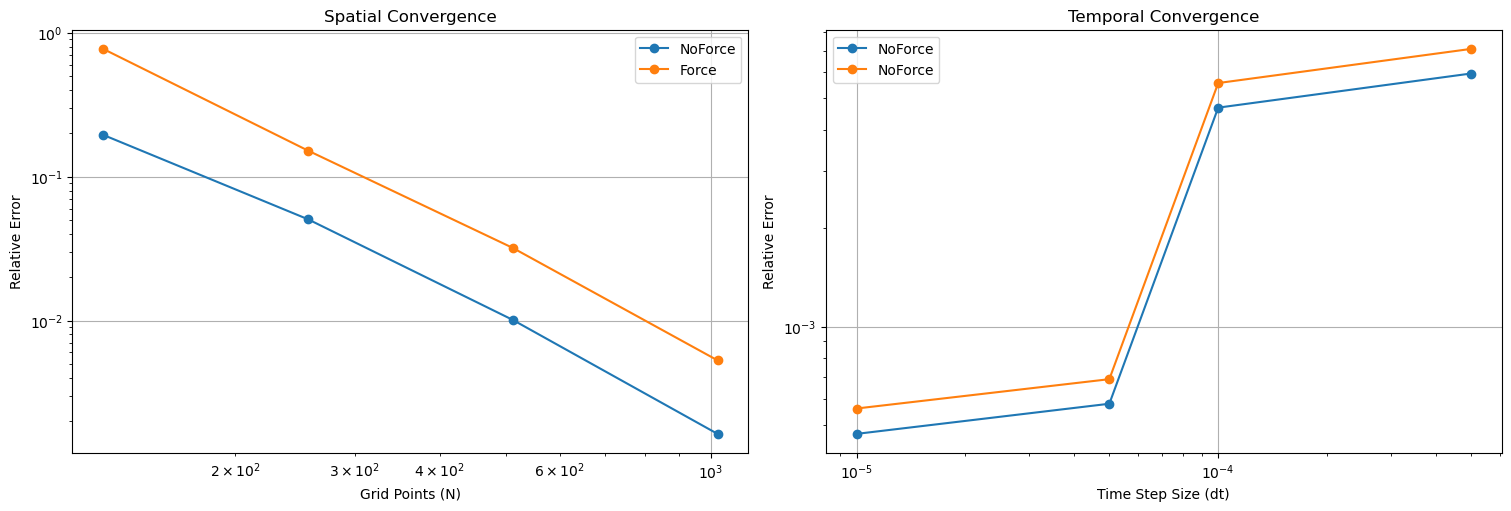

In [55]:
fig, axs = plt.subplots(1,2,figsize = (15,5), layout='constrained')

# Plot the first subplot (Solution Visualization for u_0)
axs[0].loglog(N_values[1:], errors["NoF"], '-o', label="NoForce")
axs[0].loglog(N_values[1:], errors["F"], '-o', label="Force")
axs[0].set_title(r"Spatial Convergence")
axs[0].set_xlabel("Grid Points (N)")
axs[0].set_ylabel("Relative Error")
axs[0].legend()
axs[0].grid()

axs[1].loglog(dt_values[1:], errors_dt["NoF"], '-o', label="NoForce")
axs[1].loglog(dt_values[1:], errors_dt["F"], '-o', label="NoForce")
axs[1].set_title(r"Temporal Convergence")
axs[1].set_xlabel("Time Step Size (dt)")
axs[1].set_ylabel("Relative Error")
axs[1].legend()
axs[1].grid()

# PINN

In [21]:
import sys
import os

# Add the parent directory to the sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

import torch
import numpy as np
from ml_collections import ConfigDict
from scipy.interpolate import griddata
from matplotlib.animation import FuncAnimation, PillowWriter
import matplotlib.pyplot as plt

from nv_files.Field_Generator import omega0_samples_torch
from nv_files.data_generator import solve_poisson_fft,compute_velocity,UniformSampler
from nv_files.NavierStokes import NavierStokes
from nv_files.Pseudo_Spectral_Solver import VorticitySolver2D
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [22]:
WRF_MDNN_soft = torch.load(f"./models/WRF-MDNN_soft_epoch10000.pth")
WRF_MDNN_soft.eval()

mdnn_model = torch.load(f"./models/MDNN_epoch13000.pth")
mdnn_model.eval()

NavierStokes(
  (model): MDNN(
    (activation_fn): Tanh()
    (period_layer): PeriodEmbs()
    (fourier_layer): FourierEmbs()
    (u_layer): Linear(in_features=256, out_features=256, bias=True)
    (v_layer): Linear(in_features=256, out_features=256, bias=True)
    (hidden_layers): ModuleList(
      (0-3): 4 x Linear(in_features=256, out_features=256, bias=True)
    )
    (output_layer): Linear(in_features=256, out_features=2, bias=True)
  )
)

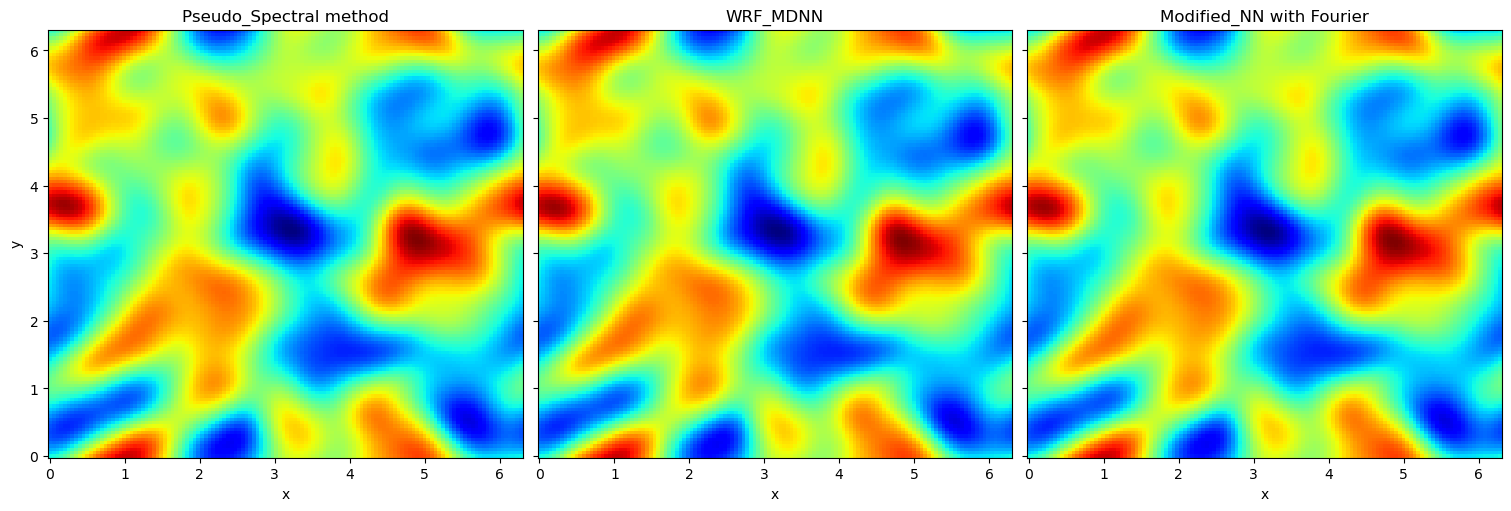

In [ ]:

N = 128
seed = 108
N_KL = 50
xgrid = np.linspace(0,2*np.pi,N)
X, Y = np.meshgrid(xgrid, xgrid)
rng = np.random.default_rng(seed)
theta = rng.normal(0, 1, (N_KL, 2,1))

import jax.numpy as jnp

data = jnp.load("./data/ns_tori.npy", allow_pickle=True).item()
w_ref = data["w"]

#w0 = omega0_samples_torch(X, Y, theta, d = 5,tau=10)

solver = VorticitySolver2D(N=128, L=1, T=2, nu=1e-2, dt=5e-4,num_sol=200, method='CN', force=None)

w_list = solver.run_simulation( np.array(w_ref[0,:,:]))
time_array = np.linspace(5e-4, 2, int(1/ 5e-4))
points = np.linspace(0, len(time_array) - 1, 200, dtype=int)


time_steps = [0] + list(time_array[points])

batch_size_initial = 128

X = torch.linspace(0, 1, batch_size_initial)*2*torch.pi  # Spatial grid in X direction
Y = torch.linspace(0, 1, batch_size_initial)*2*torch.pi  # Spatial grid in Y direction
X, Y = torch.meshgrid(X, Y)  # Create meshgrid for X, Y


dx = X[1, 0] - X[0, 0]
dy = Y[0, 1] - Y[0, 0]

fig, axs = plt.subplots(1,3,figsize = (15,5), layout='constrained', sharey=True)

def animate(i):

    axs[0].clear()
    axs[1].clear()
    axs[2].clear()

    delta_t = time_steps[i]
    w0 = w_list[i]

    # # Solve for streamfunction
    # psi = solve_poisson_fft(w0, dx, dy)

    # # Compute velocity components
    # u0, v0 = compute_velocity(psi, dx, dy)

    data_test = torch.hstack((X.reshape(-1,1),Y.reshape(-1,1),delta_t*torch.ones_like(X.reshape(-1,1)))).float()

    #initial_condition_grid = griddata((X.reshape(-1), Y.reshape(-1)), initial_condition[:,0],
    #                    (X, Y), method='cubic')

    fnnw_pred = WRF_MDNN_soft.w_net(data_test).detach().numpy()
    wrfmdnn_pred = mdnn_model.w_net(data_test).detach().numpy()

    w_pred_mdnnw = griddata((X.reshape(-1), Y.reshape(-1)), fnnw_pred.flatten(),
                        (X, Y), method='cubic')
    w_pred_wrfdnn = griddata((X.reshape(-1), Y.reshape(-1)), wrfmdnn_pred.flatten(),
                        (X, Y), method='cubic')

    # Plot the first subplot (Solution Visualization for u_0)
    im1 = axs[0].pcolormesh(X, Y, w0, cmap='jet')
    #fig.colorbar(im1)
    axs[0].set_title("Pseudo_Spectral method")
    axs[0].set_xlabel("x")
    axs[0].set_ylabel("y")

    im2 = axs[1].pcolormesh(X, Y, w_pred_wrfdnn, cmap='jet')
    #fig.colorbar(im2)
    axs[1].set_title("WRF_MDNN")
    axs[1].set_xlabel("x")

    im3 = axs[2].pcolormesh(X, Y, w_pred_mdnnw, cmap='jet')
    #fig.colorbar(im3)
    axs[2].set_title("Modified_NN with Fourier")
    axs[2].set_xlabel("x")

    return im1, im2, im3

ani = FuncAnimation(fig, animate, interval=1, blit=False, repeat=True, frames=100)    
ani.save("/results/NV_NNs.gif", dpi=300, writer=PillowWriter(fps=25))

In [ ]:
from data_generator import solve_poisson_fft,compute_velocity,UniformSampler
from Training import compute_loss

numpy_x = np.load("numpy_x.npy")
numpy_y = np.load("numpy_y.npy")
numpy_w = np.load("numpy_w.npy")

X, Y = torch.meshgrid(torch.tensor(numpy_x), torch.tensor(numpy_y),indexing="ij")
dx, dy = X[1, 0] - X[0, 0], Y[0, 1] - Y[0, 0]
w0 = torch.tensor(numpy_w).unsqueeze(-1)

psi = solve_poisson_fft(w0, dx, dy)
u0, v0 = compute_velocity(psi, dx, dy)

initial_points = torch.hstack([X.reshape(-1, 1), Y.reshape(-1, 1), torch.zeros_like(X.reshape(-1, 1))])
initial_condition = torch.hstack([w0.reshape(-1, 1), u0.reshape(-1, 1), v0.reshape(-1, 1)])

dom = torch.tensor([[0, 2 * torch.pi], [0, 2 * torch.pi]]).to(device)

fourier_emb = {"embed_scale" : 1, "embed_dim" :256, "input_dim":3}
period_emb_config = {"period": (1.0, 1.0), "axis": (0, 1)}
reparam = {"type":"weight_fact","mean":0.5,"stddev":0.1}
# Define model, optimizer, scheduler, etc.

loss_fn = torch.nn.MSELoss(reduction ='mean')

# Define model, optimizer, scheduler, etc.
wrf_MDNN_model = WRF_MDNN(num_layers=4, hidden_dim=256, out_dim=2, 
                 input_dim=3,
                 fourier_emb = fourier_emb,
                 reparam=reparam, period_emb=period_emb_config).to(device)

MDNN_model = MDNN(num_layers=4, hidden_dim=256, out_dim=2, 
                 input_dim=(3),fourier_emb = fourier_emb, period_emb = period_emb_config).to(device)

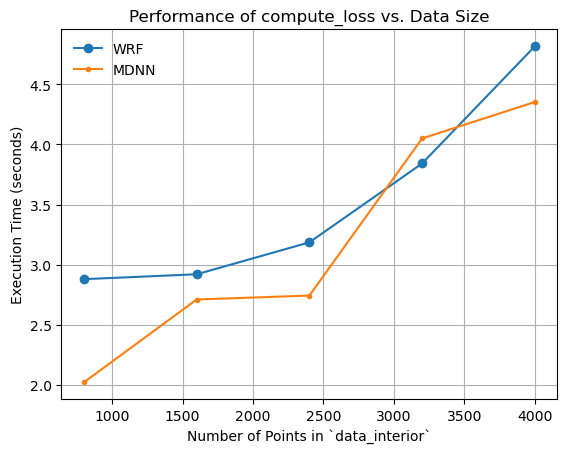

In [18]:
import time
import matplotlib.pyplot as plt

sizes = [16*i for i in range(50,300,50)]  # Varying number of points in `data_interior`
times = {"WRF":[],"MDNN":[]}
models = {"WRF":wrf_MDNN_model,"MDNN":MDNN_model}

for model in models.keys():
    for size in sizes:
        samples_interior = iter(UniformSampler(dom, size))
        timedomain = torch.linspace(0,1,size).reshape(-1, 1)
        batch = next(samples_interior)
        sorted_batch = torch.cat((batch, timedomain), dim=1).to(device)

        start_time = time.time()
        total_loss, _, _ = compute_loss(models[model], loss_fn, sorted_batch, initial_points, initial_condition, [1]*5)
        end_time = time.time()
        times[model].append(end_time - start_time)

# Plot Results
plt.plot(sizes, times["WRF"], marker='o',label = "WRF")
plt.plot(sizes, times["MDNN"], marker='.',label = "MDNN")

plt.xlabel('Number of Points in `data_interior`')
plt.ylabel('Execution Time (seconds)')
plt.title('Performance of compute_loss vs. Data Size')
plt.legend(frameon = False)
plt.grid(True)
plt.show()

In [9]:
import sys
import os

# Add the parent directory to the sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

import torch
import wandb
import numpy as np
from ml_collections import ConfigDict
from nv_files.train_nvs import train_pinn_nvs

In [ ]:
def get_deepgalerkin_config():
    config = ConfigDict()

    # Weights & Biases
    config.wandb = wandb = ConfigDict()
    wandb.project = "NVs-Training"
    wandb.name = "WRF-MDNN_soft"
    wandb.tag = None

    # General settings
    config.nn_model = "MDNN"  # Options: "NN", "WRF", "MDNN"
    config.lambdas = {"nvs":1, "cond":1, "u0":1, "v0":1, "w0":1}
    config.use_softadapt = True

    # Model-specific settings
    config.model = ConfigDict()
    config.model.input_dim = 3 
    config.model.hidden_dim = 256
    config.model.num_layers = 4
    config.model.out_dim = 2
    config.model.activation = "tanh"

    # Weight-Random-Factorization
    config.reparam = ConfigDict({"type":"weight_fact","mean":0.5,"stddev":0.1})

     # Periodic embeddings
    config.model.period_emb = ConfigDict({"period":(1.0, 1.0), "axis":(0, 1) })

    # Fourier embeddings
    config.model.fourier_emb = ConfigDict({"embed_scale":1,"embed_dim":256,"exclude_last_n":0})

    # Navier Stokes Config
    config.nu = 1e-2
    config.time_domain = 2

    # Training settings 
    config.seed = 108
    config.learning_rate = 0.001
    config.decay_rate = 0.9
    config.alpha = 0.9  # For updating loss weights
    config.iterations = 20000
    config.chunks = 16
    config.points_per_chunk = 100 
    config.scheduler_step = 2000
    config.start_scheduler = 0.1
    config.weights_update = 1
    
    return config

# CUDA for PyTorch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

config = get_deepgalerkin_config()

In [ ]:
pinn_nvs = train_pinn_nvs(config,device=device)

In [4]:
from nv_files.train_nvs import initial_conditions_samples
initial_points,w0,u0,v0,theta = initial_conditions_samples(config)

In [5]:
w0.shape[1]

10

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import grad
from torch.nn.utils import parameters_to_vector
from torch.distributions.multivariate_normal import _precision_to_scale_tril

from Base.utilities import FeatureExtractor
from copy import deepcopy
from math import sqrt, pi


class dgala(torch.nn.Module):
    def __init__(self, dga, sigma_noise=1., prior_precision=1.,prior_mean=0.,last_layer_name=None):
        super(dgala, self).__init__()

        self.dgala = deepcopy(dga)
        self.model = FeatureExtractor(deepcopy(dga.model), last_layer_name = last_layer_name)
        self._device = next(dga.model.parameters()).device

        self.lossfunc = torch.nn.MSELoss(reduction ='sum')
        self.jacobians_gn = dict()
        self.loss_laplacian = dict()
        self.H = None
        self.hessian_structure = None
        self.loss = 0
        self.temperature = 1

        self.mean = None
        self.n_params = None
        self.n_layers = None
        # ignore checks of prior mean setter temporarily, check on .fit()
        self._prior_precision = torch.tensor([prior_precision], device=self._device)
        self._prior_mean = torch.tensor([prior_mean], device=self._device)
        self.sigma_noise = torch.tensor(sigma_noise,device=self._device).float().clone().detach()

    
    @property
    def posterior_precision(self):
        """Diagonal posterior precision \\(p\\).

        Returns
        -------
        precision : torch.tensor
            `(parameters)`
        """
        return self._H_factor * self.H + torch.diag(self.prior_precision_diag)

    @property
    def posterior_covariance(self):
        """Diagonal posterior variance \\(p^{-1}\\).

        Returns
        -------
        precision : torch.tensor
            `(parameters)`
        """
        if self.hessian_structure == "diag":
            return 1 / self.posterior_precision

        elif self.hessian_structure == "full":
            
            post_scale = _precision_to_scale_tril(self.posterior_precision)
            return post_scale @ post_scale.T

    @property
    def _H_factor(self):
        sigma2 = self.sigma_noise.square()
        return 1 / sigma2 / self.temperature
    
    @property
    def prior_precision_diag(self):
        """Obtain the diagonal prior precision \\(p_0\\) constructed from either
        a scalar, layer-wise, or diagonal prior precision.

        Returns
        -------
        prior_precision_diag : torch.Tensor
        """
        if len(self.prior_precision) == 1:  # scalar
            return self.prior_precision * torch.ones(self.n_params, device=self._device)

        elif len(self.prior_precision) == self.n_params:  # diagonal
            return self.prior_precision
        
    @property
    def scatter(self):
        """Computes the _scatter_, a term of the log marginal likelihood that
        corresponds to L-2 regularization:
        `scatter` = \\((\\theta_{MAP} - \\mu_0)^{T} P_0 (\\theta_{MAP} - \\mu_0) \\).

        Returns
        -------
        [type]
            [description]
        """
        delta = (self.mean - self.prior_mean)
        return (delta * self.prior_precision_diag) @ delta

    @property
    def log_det_prior_precision(self):
        """Compute log determinant of the prior precision
        \\(\\log \\det P_0\\)

        Returns
        -------
        log_det : torch.Tensor
        """
        return self.prior_precision_diag.log().sum()

    @property
    def log_det_posterior_precision(self):
        """Compute log determinant of the posterior precision
        \\(\\log \\det P\\) which depends on the subclasses structure
        used for the Hessian approximation.

        Returns
        -------
        log_det : torch.Tensor
        """
        if self.hessian_structure == "diag":
            return self.posterior_precision.log().sum()

        elif self.hessian_structure == "full":
            return self.posterior_precision.logdet()

    @property
    def log_det_ratio(self):
        """Compute the log determinant ratio, a part of the log marginal likelihood.
        \\[
            \\log \\frac{\\det P}{\\det P_0} = \\log \\det P - \\log \\det P_0
        \\]

        Returns
        -------
        log_det_ratio : torch.Tensor
        """
        return self.log_det_posterior_precision - self.log_det_prior_precision
    
    @property
    def log_likelihood(self):
        """Compute log likelihood on the training data after `.fit()` has been called.
        The log likelihood is computed on-demand based on the loss and, for example,
        the observation noise which makes it differentiable in the latter for
        iterative updates.

        Returns
        -------
        log_likelihood : torch.Tensor
        """
        factor = - self._H_factor
        # loss used is just MSE, need to add normalizer for gaussian likelihood
        c = self.n_data  * torch.log(self.sigma_noise * sqrt(2 * pi))
        return factor * self.loss - c

    

    def fit(self,fit_data, override = True):
        """Fit the local Laplace approximation at the parameters of the model.

        Parameters
        ----------
            train_loader : torch.data.utils.DataLoader
            each iterate is a training batch (X, y);
            `train_loader.dataset` needs to be set to access \\(N\\), size of the data set
            override : bool, default=True
            whether to initialize H, loss, and n_data again; setting to False is useful for
            online learning settings to accumulate a sequential posterior approximation.
        """
        if not override:
            raise ValueError('Last-layer Laplace approximations do not support `override=False`.')
        
        self.model.eval()

        if self.model.last_layer is None:
            X = pde["data_set"][pde["PDE"][0]]
            self.n_data = pde["data_set"][pde["PDE"][0]].shape[0]
            with torch.no_grad():
                try:
                    self.model.find_last_layer(X[:1].to(self._device))
                except (TypeError, AttributeError):
                    self.model.find_last_layer(X.to(self._device))
            params = parameters_to_vector(self.model.last_layer.parameters()).detach()
            self.n_params = len(params)
            self.prior_precision = self._prior_precision
            self.prior_mean = self._prior_mean
            self._init_H()

        self.mean = parameters_to_vector(self.model.last_layer.parameters()).detach()

        if self.hessian_structure == 'diag':
            self.diagonal_Hessian(pde)

        elif self.hessian_structure == "full":
            self.full_Hessian(pde)
        
    def _init_H(self):
        if self.hessian_structure == "diag":
            self.H = torch.zeros(self.n_params,device=self._device)

        elif self.hessian_structure == "full":
            self.H = torch.zeros(self.n_params,self.n_params,device=self._device)
        
    def jacobians_GN (self,pde):
        for cond in pde["PDE"]:
            self.model.zero_grad()

            fout = getattr(self.model.model, cond)(pde["data_set"][cond])
            features = self.model._features[self.model._last_layer_name]

            loss_f = self.lossfunc(fout,torch.zeros_like(fout))
            self.loss += loss_f

            bsize,output_size = fout.shape[0],  fout.shape[-1]

            if isinstance(self.model.last_layer, nn.Linear):

                last_layer_weights = self.model.last_layer._parameters["weight"]
                last_layer_bias = self.model.last_layer._parameters["bias"]
                parameters_list = [last_layer_weights,last_layer_bias]

                jacobian = torch.zeros(bsize,last_layer_weights.numel() + last_layer_bias.numel(), )

                for i,fo in enumerate(fout):
                    grad_p = torch.autograd.grad(outputs=fo, 
                                                inputs=parameters_list, 
                                                create_graph=True, 
                                                allow_unused=True, 
                                                materialize_grads=True)

                    jacobian[i, :last_layer_weights.numel()] = grad_p[0].detach().view( -1)  # Weights
                    jacobian[i, last_layer_weights.numel():] = grad_p[1].detach().view( -1)  # Bias

            if isinstance(self.model.last_layer, Dense):

                last_layer_g = self.model.last_layer._parameters["g"]
                last_layer_v = self.model.last_layer._parameters["v"]
                last_layer_bias = self.model.last_layer._parameters["bias"]

                parameters_list = [last_layer_g,last_layer_v,last_layer_bias]
                total_g, total_v, total_bias= last_layer_g.numel(),last_layer_v.numel(),last_layer_bias.numel()

                jacobian = torch.zeros(bsize,total_g + total_v + total_bias, )

                for i,fo in enumerate(fout):
                    grad_p = torch.autograd.grad(outputs=fo, 
                                                inputs=parameters_list, 
                                                create_graph=True, 
                                                allow_unused=True, 
                                                materialize_grads=True)

                    jacobian[i, :total_g] = grad_p[0].detach().view( -1)  # Weights
                    jacobian[i, total_g:total_g + total_v] = grad_p[1].detach().view( -1)  # Bias
                    jacobian[i, total_g + total_v:] = grad_p[2].detach().view( -1)  # Bias


            identity = torch.eye(output_size).unsqueeze(0).tile(bsize, 1, 1)
            Js = torch.einsum('kp,kij->kijp', jacobian, identity).reshape(bsize, output_size, -1)

            # Store the Jacobians for each PDE condition
            self.jacobians_gn[cond] = Js


    def diagonal_Hessian(self,pde):
        self.jacobians_GN(pde)
        for cond in pde["PDE"]:
            #self.H += torch.sum(self.jacobians_gn[cond]*self.loss_laplacian[cond]*self.jacobians_gn[cond],axis=0)
            self.H += torch.sum(self.jacobians_gn[cond]*self.jacobians_gn[cond],axis=0)

    def full_Hessian(self,pde, damping_factor=1e-6):
        self.jacobians_GN(pde)
        for cond in pde["PDE"]:
            jacobian = self.jacobians_gn[cond]
            
            # Sum up the outer products of the Jacobian with itself
            self.H += torch.sum(torch.einsum('bce,bdf->bef', jacobian, jacobian), axis=0)
        
        # Add some regularization to avoid singularity
        self.H += torch.eye(self.H.shape[0], device=self._device) * damping_factor
        self.jacobians_gn = dict()

    def __call__(self, x):
        """Compute the posterior predictive on input data `X`.

        Parameters
        ----------
        x : torch.Tensor
            `(batch_size, input_shape)`

        pred_type : {'glm', 'nn'}, default='glm'
            type of posterior predictive, linearized GLM predictive or neural
            network sampling predictive. The GLM predictive is consistent with
            the curvature approximations used here

        Returns
        -------
        predictive: torch.Tensor or Tuple[torch.Tensor]
            For `likelihood='classification'`, a torch.Tensor is returned with
            a distribution over classes (similar to a Softmax).
            For `likelihood='regression'`, a tuple of torch.Tensor is returned
            with the mean and the predictive variance.
        """
        f_mu, f_var = self._glm_predictive_distribution(x)
        return f_mu, f_var


    def _glm_predictive_distribution(self, X):
        Js, f_mu = self.last_layer_jacobians(X)
        f_var = self.functional_variance(Js)
        if f_mu.shape[-1] > 1:
            f_var = torch.diagonal(f_var, dim1 = 1, dim2 = 2)
        return f_mu.detach(), f_var.detach()

    def last_layer_jacobians(self, x):
        """Compute Jacobians \\(\\nabla_{\\theta_\\textrm{last}} f(x;\\theta_\\textrm{last})\\) 
        only at current last-layer parameter \\(\\theta_{\\textrm{last}}\\).

        Parameters
        ----------
        x : torch.Tensor

        Returns
        -------
        Js : torch.Tensor
            Jacobians `(batch, last-layer-parameters, outputs)`
        f : torch.Tensor
            output function `(batch, outputs)`
        """
        f, phi = self.model.forward_with_features(x)
        bsize = phi.shape[0]
        output_size = f.shape[-1]

        if isinstance(self.model.last_layer, Dense):

            G = self.model.last_layer._parameters["g"].detach()
            V = self.model.last_layer._parameters["v"].detach()

            dydG = (phi @ V).view(bsize, 1)  # Shape (batch_size, 1)
            dydV = (G.item() * phi).view(bsize, 20) 

            jacobian = torch.zeros(bsize, 21)  # 1 for G, 20 for V, and 1 for bias

            # Fill in the Jacobian
            jacobian[:, 0] = dydG.view(-1)  # Fill ∂y/∂G
            jacobian[:, 1:] = dydV  # Fill ∂y/∂V

            phi = jacobian.clone()

        if self.model.last_layer.bias is not None:
            phi = torch.cat([phi, torch.ones(f.shape[0],1).to(self._device)], dim=1)
        # calculate Jacobians using the feature vector 'phi'
        identity = torch.eye(output_size, device=x.device).unsqueeze(0).tile(bsize, 1, 1)
        # Jacobians are batch x output x params
        Js = torch.einsum('kp,kij->kijp', phi, identity).reshape(bsize, output_size, -1)
        # if self.model.last_layer.bias is not None:
        #     Js = torch.cat([Js, identity], dim=2)
        return Js, f.detach()
    

    def functional_variance(self, Js: torch.Tensor) -> torch.Tensor:
        if self.hessian_structure == "diag":
            return torch.einsum('ncp,p,nkp->nck', Js, self.posterior_covariance, Js)

        elif self.hessian_structure == "full":
            return torch.einsum('ncp,pq,nkq->nck', Js, self.posterior_covariance, Js)
    
  
    def log_marginal_likelihood(self, prior_precision=None, sigma_noise=None):
        """Compute the Laplace approximation to the log marginal likelihood subject
        to specific Hessian approximations that subclasses implement.
        Requires that the Laplace approximation has been fit before.
        The resulting torch.Tensor is differentiable in `prior_precision` and
        `sigma_noise` if these have gradients enabled.
        By passing `prior_precision` or `sigma_noise`, the current value is
        overwritten. This is useful for iterating on the log marginal likelihood.

        Parameters
        ----------
        prior_precision : torch.Tensor, optional
            prior precision if should be changed from current `prior_precision` value
        sigma_noise : [type], optional
            observation noise standard deviation if should be changed

        Returns
        -------
        log_marglik : torch.Tensor
        """
        # update prior precision (useful when iterating on marglik)
        if prior_precision is not None:
            self.prior_precision = prior_precision

        # update sigma_noise (useful when iterating on marglik)
        if sigma_noise is not None:
            self.sigma_noise = sigma_noise

        return self.log_likelihood - 0.5 * (self.log_det_ratio + self.scatter)
    
    def optimize_marginal_likelihood(self, error_tolerance=1e-3, max_iter=300, lr=1e-2):
        """Optimize the log prior and log sigma by maximizing the marginal likelihood."""

        log_prior_prec = self.prior_precision.log()
        log_prior_prec.requires_grad = True

        log_sigma_noise = self.sigma_noise.log()
        log_sigma_noise.requires_grad = True

        hyper_optimizer = torch.optim.Adam([log_prior_prec, log_sigma_noise], lr=lr)

        error,n_iter = float('inf'),0  # Initialize error

        while error > error_tolerance and n_iter < max_iter:
            prev_log_prior, prev_log_sigma = log_prior_prec.detach().clone(), log_sigma_noise.detach().clone()

            hyper_optimizer.zero_grad()

            # Calculate negative marginal likelihood
            neg_marglik = -self.log_marginal_likelihood(log_prior_prec.exp(), log_sigma_noise.exp())
            neg_marglik.backward(retain_graph=True)

            # Perform optimization step
            hyper_optimizer.step()

            # Calculate the error based on the change in hyperparameters
            error = 0.5 * (torch.abs(log_prior_prec - prev_log_prior) + torch.abs(log_sigma_noise - prev_log_sigma)).item()

            n_iter += 1

            # Optional: log progress for monitoring
            if n_iter % 100 == 0:
                print(f"Iteration {n_iter}, Error: {error:.5f}, neg_marglik: {neg_marglik.item():.5f}")

        self.prior_precision = log_prior_prec.detach().exp()
        self.log_sigma_noise = log_sigma_noise.detach().exp()

        if n_iter == max_iter:
            print(f"Maximum iterations ({max_iter})reached, sigma : {self.sigma_noise.item()}, prior: {self.prior_precision.item()}.")
